# Project: Investigate a Dataset - soccer database
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> This soccer database comes from Kaggle and is well suited for data analysis and machine learning. It contains data for soccer matches, players, and teams from several European countries from 2008 to 2016. 


### Question(s) for Analysis

> Which teams are champions in top five league for every season ? 

> What teams improved the most over the time period ? and What team attributes lead to the most victories ?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplt
%matplotlib inline
import seaborn as sns
sns.set(rc = {'figure.figsize':(20,8)})
import sqlite3

<a id='wrangling'></a>
## Data Wrangling

### Load data from database

In [2]:
# number of tables in database
connection = sqlite3.connect('database.sqlite')
tables = pd.read_sql("SELECT name from sqlite_sequence", connection)
connection.close()
tables

,name
0,Team
1,Country
2,League
3,Match
4,Player
5,Player_Attributes
6,Team_Attributes


In [3]:
# load all dataframes
connection = sqlite3.connect('database.sqlite')

# load country, league and match dataframe
df_country = pd.read_sql('select * from Country', connection)
df_league = pd.read_sql('select * from League', connection)
df_match = pd.read_sql('select * from Match', connection)

# load player and player attributes dataframe
df_player = pd.read_sql('select * from Player', connection)
df_player_att = pd.read_sql('select * from Player_Attributes', connection)

# load team and team attributes dataframe
df_team = pd.read_sql('select * from Team', connection)
df_team_att = pd.read_sql('select * from Team_Attributes', connection)

connection.close()

In [4]:
df_match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


### Reduce number of dataframes by mapping to three main dataframes

In [5]:
# mapping country with match
df_match['country_id'] = df_match['country_id'].map(dict(df_country.values))

In [6]:
# mapping league with match
df_match['league_id'] = df_match['league_id'].map(dict(df_league[['id','name']].values))

In [7]:
# mapping home team with match
df_match['home_team_api_id'] = df_match['home_team_api_id'].map(dict(df_team[['team_api_id', 'team_long_name']].values))

In [8]:
# mapping away team with match
df_match['away_team_api_id'] = df_match['away_team_api_id'].map(dict(df_team[['team_api_id', 'team_long_name']].values))

In [9]:
# rename columns of match dataframe after mapping
df_match.rename(columns={'country_id' : 'country', 'league_id' : 'league', 'home_team_api_id' : 'home team', 'away_team_api_id' : 'away team'}, inplace=True)

In [10]:
df_match.head()

,id,country,league,season,stage,date,match_api_id,home team,away team,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,492473,KRC Genk,Beerschot AC,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,492474,SV Zulte-Waregem,Sporting Lokeren,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,492475,KSV Cercle Brugge,RSC Anderlecht,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,492476,KAA Gent,RAEC Mons,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,492477,FCV Dender EH,Standard de Liège,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [11]:
# mapping player with player attributes
df_player_att['player_api_id'] = df_player_att['player_api_id'].map(dict(df_player[['player_api_id', 'player_name']].values))

In [12]:
# rename column after mapping
df_player_att.rename(columns={'player_api_id' : 'player_name'}, inplace=True)

In [13]:
df_player_att.head()

,id,player_fifa_api_id,player_name,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,Aaron Appindangoye,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,Aaron Appindangoye,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,Aaron Appindangoye,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,Aaron Appindangoye,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,Aaron Appindangoye,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [14]:
# mapping team with team attributes
df_team_att['team_api_id'] = df_team_att['team_api_id'].map(dict(df_team[['team_api_id', 'team_long_name']].values))

In [15]:
# rename column after mapping
df_team_att.rename(columns={'team_api_id' : 'team_name'}, inplace=True)

In [16]:
df_team_att.head()

,id,team_fifa_api_id,team_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,FC Aarau,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,FC Aarau,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,FC Aarau,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,Aberdeen,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,Aberdeen,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


### Data cleaning

In [17]:
# Match dataframe have alot of unneccesary columns and mising data, so i select important columns that will use in my analysis.
df_match = df_match.loc[:, 'country' : 'away_team_goal']

In [18]:
# drop match_api_id
df_match.drop('match_api_id', axis=1, inplace=True)

In [ ]:
df_match.isnull().sum()

In [ ]:
df_match.head()

,country,league,season,stage,date,home team,away team,home_team_goal,away_team_goal
0,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,KRC Genk,Beerschot AC,1,1
1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,SV Zulte-Waregem,Sporting Lokeren,0,0
2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,KSV Cercle Brugge,RSC Anderlecht,0,3
3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,KAA Gent,RAEC Mons,5,0
4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,FCV Dender EH,Standard de Liège,1,3


In [ ]:
df_team_att.isnull().sum()

id                                  0
team_fifa_api_id                    0
team_name                           0
date                                0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64

In [ ]:
# drop id, team_fifa_api_id and buildUpPlayDribbling
df_team_att.drop(['id', 'team_fifa_api_id', 'buildUpPlayDribbling'], axis=1, inplace=True)

In [ ]:
df_team_att.head()

,team_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,FC Aarau,2010-02-22 00:00:00,60,Balanced,Little,50,Mixed,Organised,60,Normal,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,FC Aarau,2014-09-19 00:00:00,52,Balanced,Normal,56,Mixed,Organised,54,Normal,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,FC Aarau,2015-09-10 00:00:00,47,Balanced,Normal,54,Mixed,Organised,54,Normal,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,Aberdeen,2010-02-22 00:00:00,70,Fast,Little,70,Long,Organised,70,Risky,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,Aberdeen,2011-02-22 00:00:00,47,Balanced,Little,52,Mixed,Organised,53,Normal,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [ ]:
df_player_att.isnull().sum()

id                        0
player_fifa_api_id        0
player_name               0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

In [ ]:
# drop null value, its very small
df_player_att.dropna(inplace=True)

In [ ]:
# drop id, player_fifa_api_id
df_player_att.drop(['id', 'player_fifa_api_id'], axis=1, inplace=True)

In [ ]:
df_player_att.head()

,player_name,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,Aaron Appindangoye,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,Aaron Appindangoye,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,Aaron Appindangoye,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,Aaron Appindangoye,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,Aaron Appindangoye,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


### feature engineering and extract

In [ ]:
# convert date to datetime
df_match['date'] = pd.to_datetime(df_match['date'])

In [ ]:
def HomePoints(row):
    """Clasification of match result for home team"""

    if row['home_team_goal'] > row['away_team_goal']:
        return 3
    elif row['home_team_goal'] < row['away_team_goal']:
        return 0
    else:
        return 1

In [ ]:
# create new feature for home point
df_match['home_team_point'] = df_match.apply(HomePoints, axis=1)

In [ ]:
def AwayPoints(row):
    """Clasification of match result for away team"""

    if row['away_team_goal'] > row['home_team_goal']:
        return 3
    elif row['away_team_goal'] < row['home_team_goal']:
        return 0
    else:
        return 1

In [ ]:
# create new feature for away point
df_match['away_team_point'] = df_match.apply(AwayPoints, axis=1)

In [ ]:
def victory(row):
    """Clasification of match victory"""

    if row['away_team_goal'] > row['home_team_goal']:
        return row['away team']
    elif row['away_team_goal'] < row['home_team_goal']:
        return row['home team']
    else:
        return 'Draw'

In [ ]:
# create feature for victory
df_match['match_victory'] = df_match.apply(victory, axis=1)

In [ ]:
df_match.head()

,country,league,season,stage,date,home team,away team,home_team_goal,away_team_goal,home_team_point,away_team_point,match_victory
0,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,KRC Genk,Beerschot AC,1,1,1,1,Draw
1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,SV Zulte-Waregem,Sporting Lokeren,0,0,1,1,Draw
2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,KSV Cercle Brugge,RSC Anderlecht,0,3,0,3,RSC Anderlecht
3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,KAA Gent,RAEC Mons,5,0,3,0,KAA Gent
4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,FCV Dender EH,Standard de Liège,1,3,0,3,Standard de Liège


<a id='eda'></a>
## Exploratory Data Analysis

### Which teams are champions in top five league for every season?

In [ ]:
# total home points for every team
home_points = df_match.groupby(['league', 'home team', 'season']).sum()['home_team_point'].to_dict()

In [ ]:
# convert to dataframe
rows = []
for key, value in home_points.items():
    row = [key[0], key[1], key[2], value]
    rows.append(row)

df_home_points = pd.DataFrame(rows, columns=['league', 'team', 'season', 'home_points'])

In [ ]:
# total away points for every team
away_points = df_match.groupby(['league', 'away team', 'season']).sum()['away_team_point'].to_dict()

In [ ]:
# convert to dataframe
rows = []
for key, value in away_points.items():
    row = [key[0], key[1], key[2], value]
    rows.append(row)

df_away_points = pd.DataFrame(rows, columns=['league', 'team', 'season', 'away_points'])

In [ ]:
# total points for every team
df_total_points = df_home_points
df_total_points['away_points'] = df_away_points['away_points']
df_total_points['total_points'] = df_total_points['home_points'] + df_total_points['away_points']

In [ ]:
df_total_points.head()

,league,team,season,home_points,away_points,total_points
0,Belgium Jupiler League,Beerschot AC,2008/2009,30,12,42
1,Belgium Jupiler League,Beerschot AC,2009/2010,22,13,35
2,Belgium Jupiler League,Beerschot AC,2010/2011,20,6,26
3,Belgium Jupiler League,Beerschot AC,2011/2012,28,8,36
4,Belgium Jupiler League,Beerschot AC,2012/2013,15,8,23


In [ ]:
# select top five league
df_top_league = pd.concat([df_total_points.iloc[117:741],df_total_points.iloc[1238:1398]], ignore_index=True)

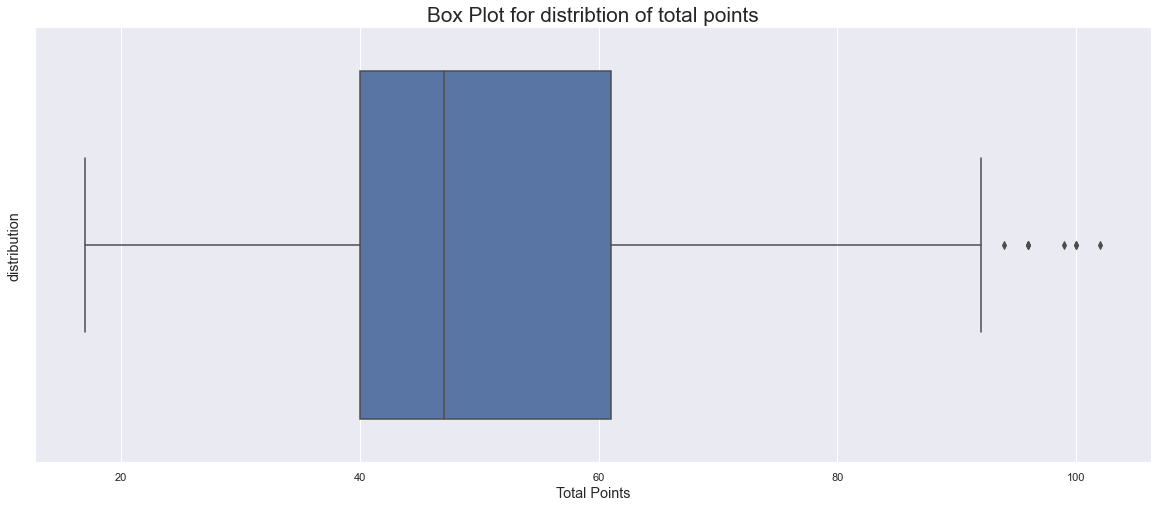

In [ ]:
# box plot for total points
plot_1 = sns.boxplot(data=df_top_league, x='total_points');
# labeled the plot
plot_1.set_xlabel('Total Points', fontsize='large');
plot_1.set_ylabel('distribution', fontsize='large');
plot_1.set_title('Box Plot for distribtion of total points', fontsize='xx-large');

In [ ]:
# list of all champion team 
teams = []
dict = df_top_league.groupby(['league', 'season']).max().total_points.to_dict()
for key, value in dict.items():
    team = df_top_league[(df_top_league['season'] == key[1])  & (df_top_league['league'] == key[0]) & (df_top_league['total_points'] == value)]['team'].values
    teams.append(str(team)[2:-2])

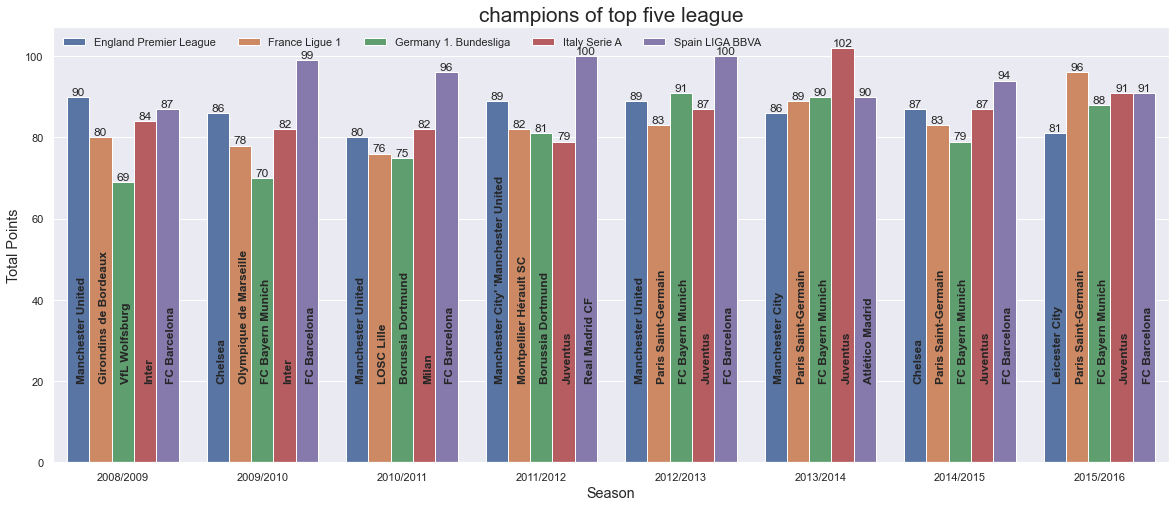

In [ ]:
# plot for all champions teams in top five league for every season 
plot_2 = sns.barplot(data=df_top_league, x='season', y='total_points', hue='league', estimator=max, ci=None);

# show number of team's points in every season
for container in plot_2.containers:
    plot_2.bar_label(container)

# show team's champion in every season
bins = plot_2.patches
for rect, label in zip(bins,teams):
    plot_2.text(rect.get_x() + rect.get_width() / 2 -.01, 20, label, rotation="vertical", fontweight='bold')
    
# labeled the plot
plot_2.set_title('champions of top five league', fontsize='xx-large');
plot_2.set_ylabel('Total Points', fontsize='large');
plot_2.set_xlabel('Season', fontsize='large');
pyplt.legend(loc='upper left',frameon=False, ncol=5);

### What teams improved the most over the time period ? and What team attributes lead to the most victories ?

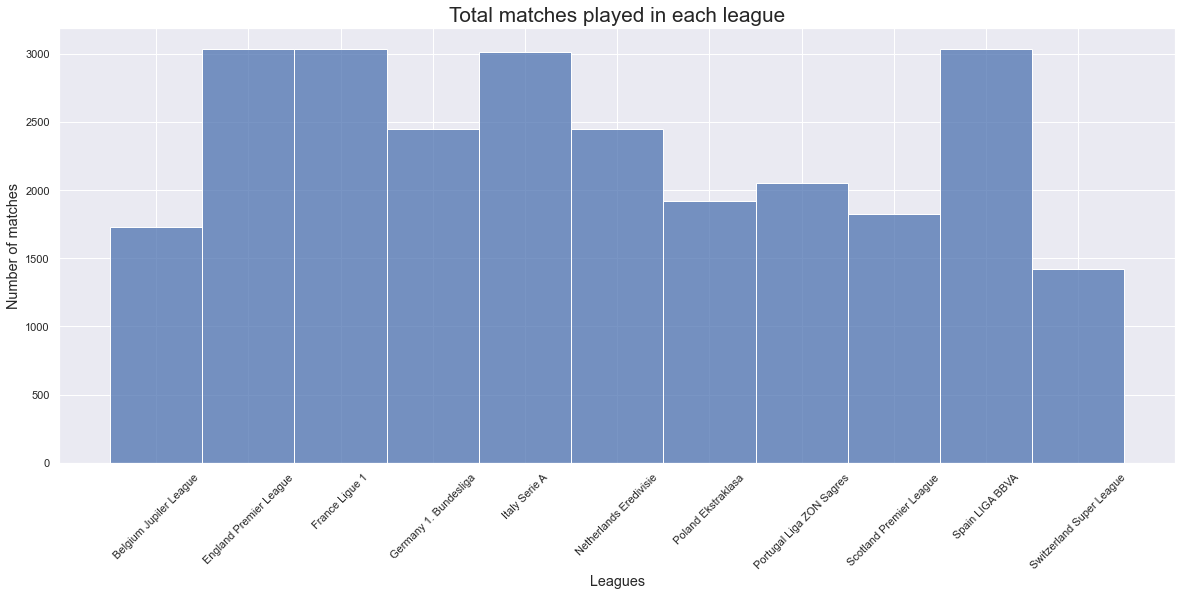

In [ ]:
# histogram for total match in every league
plot_3 = sns.histplot(data=df_match, x='league');
pyplt.xticks(rotation= 45);

# labeled the plot
plot_3.set_xlabel('Leagues', fontsize='large');
plot_3.set_ylabel('Number of matches', fontsize='large');
plot_3.set_title('Total matches played in each league', fontsize='xx-large');

In [ ]:
# most ten teams wins from all leagues
df_match['match_victory'].value_counts()[1:6]

FC Barcelona         234
Real Madrid CF       228
Celtic               218
FC Bayern Munich     193
Manchester United    192
Name: match_victory, dtype: int64

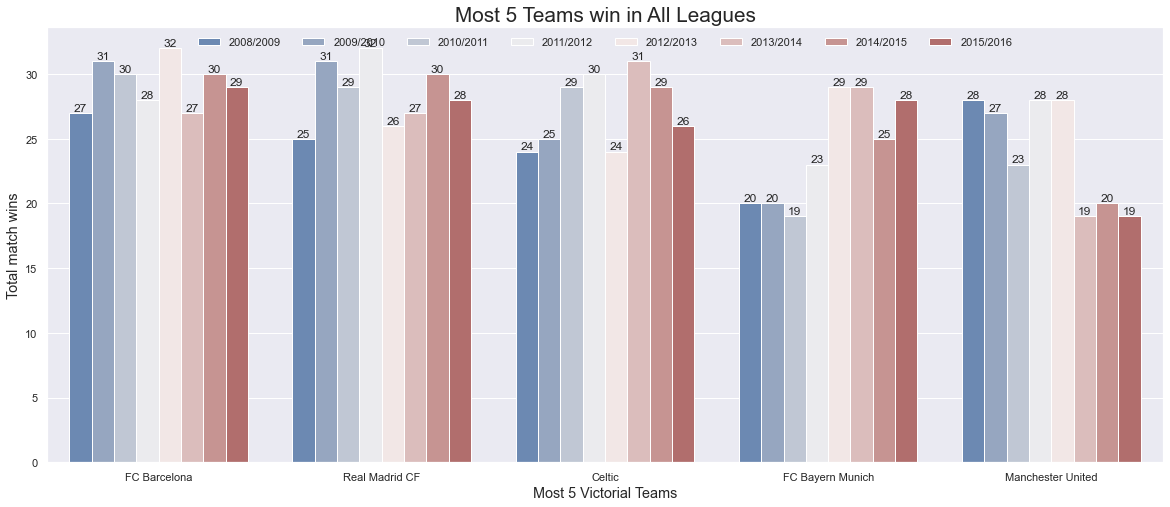

In [ ]:
# plot for top five team wins in all leagues
plot_4 = sns.countplot(data=df_match, x='match_victory',hue='season', order=pd.value_counts(df_match['match_victory']).iloc[1:6].index, palette='vlag');

# show number of matches for every season
for container in plot_4.containers:
    plot_4.bar_label(container)

# labeled the plot
plot_4.set_xlabel('Most 5 Victorial Teams', fontsize='large');
plot_4.set_ylabel('Total match wins', fontsize='large');
plot_4.set_title('Most 5 Teams win in All Leagues', fontsize='xx-large');
pyplt.legend(loc='upper center' ,frameon=False, ncol=8);

##### Notice that most victorial team lead to best team attributes so i will take FC Barcelona and Real Madrid CF to analysis best team attributes.

In [ ]:
# FC Barcelona's attributes lead to victory
barca_att = df_team_att[df_team_att['team_name'] == 'FC Barcelona']
barca_att

,team_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
118,FC Barcelona,2010-02-22 00:00:00,42,Balanced,Little,30,Short,Free Form,65,Normal,...,70,Lots,Free Form,70,High,30,Contain,70,Wide,Offside Trap
119,FC Barcelona,2011-02-22 00:00:00,43,Balanced,Little,34,Mixed,Free Form,59,Normal,...,68,Lots,Free Form,67,High,43,Press,68,Wide,Cover
120,FC Barcelona,2012-02-22 00:00:00,24,Slow,Little,25,Short,Free Form,37,Normal,...,54,Normal,Free Form,66,Medium,63,Press,66,Normal,Cover
121,FC Barcelona,2013-09-20 00:00:00,35,Balanced,Little,32,Short,Free Form,37,Normal,...,35,Normal,Free Form,61,Medium,63,Press,65,Normal,Cover
122,FC Barcelona,2014-09-19 00:00:00,35,Balanced,Normal,32,Short,Free Form,37,Normal,...,35,Normal,Free Form,61,Medium,63,Press,65,Normal,Cover
123,FC Barcelona,2015-09-10 00:00:00,36,Balanced,Normal,51,Mixed,Free Form,36,Normal,...,56,Normal,Free Form,61,Medium,65,Press,65,Normal,Cover


In [ ]:
# Real Madrid CF's attributes lead to victory
real_att = df_team_att[df_team_att['team_name'] == 'Real Madrid CF']
real_att

,team_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
1048,Real Madrid CF,2010-02-22 00:00:00,55,Balanced,Little,30,Short,Free Form,70,Risky,...,70,Lots,Free Form,65,Medium,40,Press,65,Normal,Offside Trap
1049,Real Madrid CF,2011-02-22 00:00:00,54,Balanced,Little,39,Mixed,Free Form,67,Risky,...,67,Lots,Free Form,68,High,55,Press,55,Normal,Cover
1050,Real Madrid CF,2012-02-22 00:00:00,45,Balanced,Little,35,Mixed,Free Form,71,Risky,...,73,Lots,Free Form,49,Medium,60,Press,68,Wide,Cover
1051,Real Madrid CF,2013-09-20 00:00:00,50,Balanced,Little,41,Mixed,Organised,68,Risky,...,72,Lots,Free Form,39,Medium,49,Press,65,Normal,Cover
1052,Real Madrid CF,2014-09-19 00:00:00,50,Balanced,Normal,41,Mixed,Organised,68,Risky,...,69,Lots,Free Form,39,Medium,49,Press,65,Normal,Cover
1053,Real Madrid CF,2015-09-10 00:00:00,50,Balanced,Normal,46,Mixed,Free Form,61,Normal,...,63,Normal,Free Form,52,Medium,60,Press,63,Normal,Cover


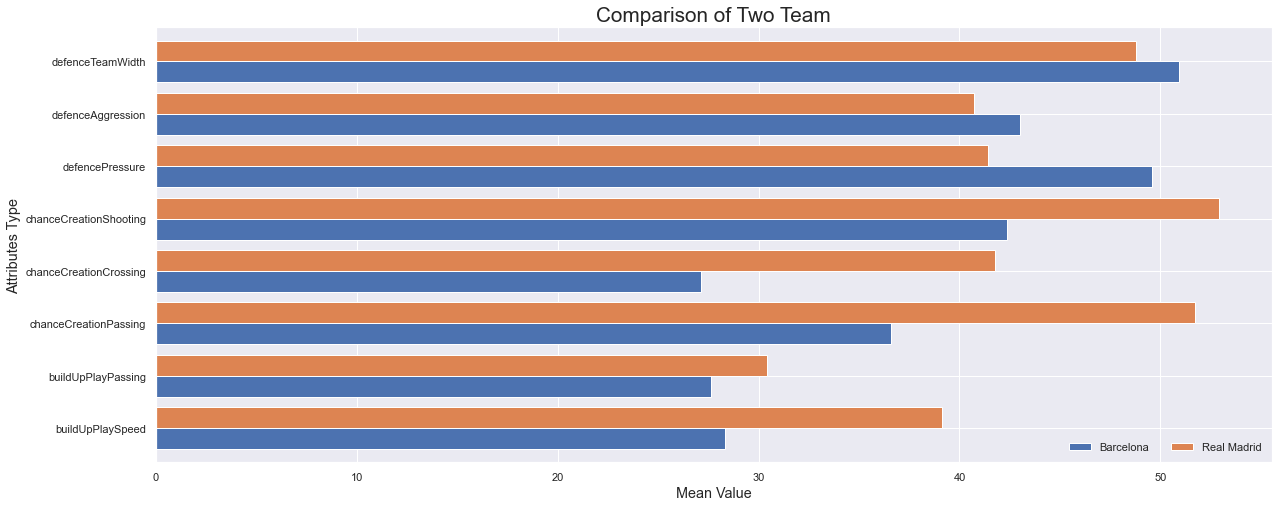

In [ ]:
# compare between FC Barcelona's attributes and Real Madrid CF's attributes
compare = pd.DataFrame(barca_att.describe().mean(), columns=['Barcelona'])
compare['Real Madrid'] = real_att.describe().mean()

plot_5 = compare.plot.barh(width=0.80)

# labeled the plot
plot_5.set_ylabel('Attributes Type', fontsize='large');
plot_5.set_xlabel('Mean Value', fontsize='large');
plot_5.set_title('Comparison of Two Team', fontsize='xx-large');
pyplt.legend(loc=0 ,frameon=False, ncol=8);

<a id='conclusions'></a>
## Conclusions

> Fc Barcelona the most team successfull in La Liga by six title in this period.

> In italy, Juventus have five sequence title with the most.

> In germany, FC Bayern Munich have the most title by five with four sequence.

> In france, Paris Saint-Germain have the most with four sequence title.

> In england, most win title by Manchester United with three tilte then manchester city with two.

> Season 2011/2012 Manchester city win title by the different goals with manchester united.

> Most succesfull team in europe through this period is FC Barcelona with most title and wins.

## Limitation

> Dadaframe of match have alot of columns with missed values but this columns removed because this not helpfull for my analysis.

> Dataframe of team;s attributes have one columns with missed values over 60% missed and there is another columns with the same function so i remove it.